In [616]:
#Imports and API Key
#building in offsets

#Imports and API Key

import pandas as pd
import quandl
from scipy import stats
import scipy
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import numpy as np
import sys

from sklearn.pipeline import Pipeline

from basis_expansions.basis_expansions import (
    Polynomial, LinearSpline)

from regression_tools.dftransformers import (
    ColumnSelector, Identity, FeatureUnion, MapFeature, Intercept)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Ridge
from sklearn.linear_model import RidgeClassifier

import seaborn as sns


import xgboost as xgb

%aimport dataclean

quandl.ApiConfig.api_key = 'm8FYMyoCaJSbTrBASNHh'

In [617]:
#pulling data from Quandl

data = pd.read_csv('datasources2.csv') #staging the QUANDL keys to pull in CSV
cols = list(data['Var_name'].astype('str'))
dataset = quandl.get([val for val in data['Quandl Key']]) #looping through the QUANDL keys to pull it into one DF
dataset.columns = cols

In [618]:
#pulling FED Yield Curve data

yields = pd.read_csv('Fed10Y_3M.csv')
yields['Date'] = pd.to_datetime(yields['Date'])
yields['Date'] = yields['Date'].apply(lambda x: x.strftime('%Y-%m'))
yields = yields.set_index('Date')
yields = yields.drop(['3 Month Treasury Yield', 'Rec_prob', 'NBER_Rec','Unnamed: 7'], axis=1) 

In [619]:
#need to write in special logic to factor in for 3YRT being a daily

treas = dataset['3YRT']
dataset = dataset.drop(columns = ['3YRT'])

In [620]:
treas = treas.resample('MS').mean()

In [621]:
## back to working on the general data
dataset.index = dataset.index.strftime('%Y-%m') #converting the datetime index to Y/M so it is collapsable
dataset = dataset.groupby(dataset.index, as_index=True).agg(sum) #collapsing by Y/M

In [622]:
#readd 3YRT back into data

dataset = dataset.join(treas, how='outer')

In [623]:
#converting GDP quarterly data into monthly - need to convert it so it fills in the following 3 months

dataset = dataclean.convert_q_to_m(dataset, 'GDP')

#converting consumer sentiment into monthly

dataset = dataclean.convert_q_to_m(dataset, 'CONS_SENT')

In [624]:
offset_dict = {'PMI':1, 'UNR':1, 'YUNR':1,'US_NHOME_SALES':1, 'PART_TIME':1, 'CPPR_PRICE':1, 'HOUS_PERMS':1, 'HOUS_STARTS':1, 'CAP_UTIL':1, 'PERS_SAVINGS':3, 'EXPORTS':3, 'IMPORTS':3, 'TRADE_BALANCE':3, 'US_M2':1, 'US_NHOME_SALES':1,'PPI':1,'CPI':1} #positives shift down, negatives shift up. Goal of this dict is to align data to when it gets released

In [625]:
for entry in offset_dict:
    #print(entry)
    #print(offset_dict[entry])
    dataset[str(entry)] = dataset[str(entry)].shift(offset_dict[entry])

In [626]:
#calculating change in GDP and converting Y into categorical values 
dataset['Recession'] = ((dataset['GDP'] - dataset['GDP'].shift(3)) < 0).astype(int)
#dataset = dataset.drop(columns = ['GDP','Recession']) #dropping calc column and recession column from dataset, experimenting with taking out fed funds rate

In [627]:
#merge fed interest rate data here
dataset = dataset.join(yields, how='outer')

In [628]:
dataset.shape

(1286, 24)

In [629]:
dataset = dataset[552:]

In [630]:
dataset = dataset[:-12]

In [631]:
#substituting mean value in for missing values and adding dummy column to indicate where done

for col in dataset.columns:
    if str(col)=='Recession':
        continue
    dataclean.clean_zeros(col, dataset)

In [632]:
dataset['3YRT'] = dataset['3YRT'].fillna(dataset['3YRT'].mean())

In [633]:
dataset.head()

PMI   UNR   YUNR  CONS_SENT  PART_TIME  CPPR_PRICE  HOUS_PERMS  \
1959-01-01 60.500 6.200 12.100     90.800   1081.000     165.089    1331.222   
1959-02-01 64.400 6.000 11.600     90.800   1022.000     165.089    1331.222   
1959-03-01 66.900 5.900 11.100     90.800    973.000     165.089    1331.222   
1959-04-01 67.100 5.600 11.100     90.800   1102.000     165.089    1331.222   
1959-05-01 66.900 5.200 10.800     95.300   1086.000     165.089    1331.222   

            HOUS_STARTS  CAP_UTIL  PERS_SAVINGS  EXPORTS  IMPORTS  \
1959-01-01     1429.532    69.480         8.779 1349.000 1091.000   
1959-02-01     1657.000    69.480         8.779 1401.000 1156.000   
1959-03-01     1667.000    69.480         8.779 1339.000 1139.000   
1959-04-01     1620.000    69.480        11.300 1314.000 1166.000   
1959-05-01     1590.000    69.480        10.600 1256.000 1202.000   

            TRADE_BALANCE  INT_RATE    US_M2  US_NHOME_SALES    PPI    CPI  \
1959-01-01        258.000     2.480 4028.724         606.030 31.600 13.254   
1959-02-01        245.000     2.430  286.600         606.030 31.700 13.299   
1959-03-01        200.000     2.800  287.700         606.030 31.700 13.254   
1959-04-01        148.000     2.960  289.200         606.030 31.700 13.254   
1959-05-01         54.000     2.900  290.100         606.030 31.800 13.299   

                GDP  3YRT  Recession  10 Year Treasury Yield  \
1959-01-01 3121.936 5.572      0.000                   4.020   
1959-02-01 3121.936 5.572      0.000                   3.960   
1959-03-01 3121.936 5.572      0.000                   3.990   
1959-04-01 3192.380 5.572      0.000                   4.120   
1959-05-01 3192.380 5.572      0.000                   4.310   

            3 Month Treasury Yield (Bond Equivalent Basis)  Spread  \
1959-01-01                                           2.880   1.140   
1959-02-01                                           2.760   1.200   
1959-03-01                                           2.860   1.130   
1959-04-01                                           3.010   1.110   
1959-05-01                                           2.900   1.410   

            CPPR_PRICE_PXY  HOUS_PERMS_PXY  HOUS_STARTS_PXY  CAP_UTIL_PXY  \
1959-01-01               1               1                1             1   
1959-02-01               1               1                0             1   
1959-03-01               1               1                0             1   
1959-04-01               1               1                0             1   
1959-05-01               1               1                0             1   

            PERS_SAVINGS_PXY  US_M2_PXY  US_NHOME_SALES_PXY  CPI_PXY  
1959-01-01                 1          1                   1        0  
1959-02-01                 1          0                   1        0  
1959-03-01                 1          0                   1        0  
1959-04-01                 0          0                   1        0  
1959-05-01                 0          0                   1        0

In [634]:
#adding momentum factors

momentum_cols = list(dataset.columns[:-6])

momentum_cols.remove('PPI') #removing PPI and CPI because they need a different transformation
momentum_cols.remove('CPI')
momentum_cols.remove('Recession')

for i in [1,3,12]:
    for col in momentum_cols:
        dataclean.create_momentum(col,dataset,i)

In [635]:
#CPI Calcs

for i in [1,3,12]:
    for col in ['CPI','PPI']:
        dataclean.infl_momentum(col,dataset,i)

In [636]:
pd.set_option('display.max_columns', None)
dataset.head()

PMI   UNR   YUNR  CONS_SENT  PART_TIME  CPPR_PRICE  HOUS_PERMS  \
1959-01-01 60.500 6.200 12.100     90.800   1081.000     165.089    1331.222   
1959-02-01 64.400 6.000 11.600     90.800   1022.000     165.089    1331.222   
1959-03-01 66.900 5.900 11.100     90.800    973.000     165.089    1331.222   
1959-04-01 67.100 5.600 11.100     90.800   1102.000     165.089    1331.222   
1959-05-01 66.900 5.200 10.800     95.300   1086.000     165.089    1331.222   

            HOUS_STARTS  CAP_UTIL  PERS_SAVINGS  EXPORTS  IMPORTS  \
1959-01-01     1429.532    69.480         8.779 1349.000 1091.000   
1959-02-01     1657.000    69.480         8.779 1401.000 1156.000   
1959-03-01     1667.000    69.480         8.779 1339.000 1139.000   
1959-04-01     1620.000    69.480        11.300 1314.000 1166.000   
1959-05-01     1590.000    69.480        10.600 1256.000 1202.000   

            TRADE_BALANCE  INT_RATE    US_M2  US_NHOME_SALES    PPI    CPI  \
1959-01-01        258.000     2.480 4028.724         606.030 31.600 13.254   
1959-02-01        245.000     2.430  286.600         606.030 31.700 13.299   
1959-03-01        200.000     2.800  287.700         606.030 31.700 13.254   
1959-04-01        148.000     2.960  289.200         606.030 31.700 13.254   
1959-05-01         54.000     2.900  290.100         606.030 31.800 13.299   

                GDP  3YRT  Recession  10 Year Treasury Yield  \
1959-01-01 3121.936 5.572      0.000                   4.020   
1959-02-01 3121.936 5.572      0.000                   3.960   
1959-03-01 3121.936 5.572      0.000                   3.990   
1959-04-01 3192.380 5.572      0.000                   4.120   
1959-05-01 3192.380 5.572      0.000                   4.310   

            3 Month Treasury Yield (Bond Equivalent Basis)  Spread  \
1959-01-01                                           2.880   1.140   
1959-02-01                                           2.760   1.200   
1959-03-01                                           2.860   1.130   
1959-04-01                                           3.010   1.110   
1959-05-01                                           2.900   1.410   

            CPPR_PRICE_PXY  HOUS_PERMS_PXY  HOUS_STARTS_PXY  CAP_UTIL_PXY  \
1959-01-01               1               1                1             1   
1959-02-01               1               1                0             1   
1959-03-01               1               1                0             1   
1959-04-01               1               1                0             1   
1959-05-01               1               1                0             1   

            PERS_SAVINGS_PXY  US_M2_PXY  US_NHOME_SALES_PXY  CPI_PXY  \
1959-01-01                 1          1                   1        0   
1959-02-01                 1          0                   1        0   
1959-03-01                 1          0                   1        0   
1959-04-01                 0          0                   1        0   
1959-05-01                 0          0                   1        0   

            PMI_1m_shift  UNR_1m_shift  YUNR_1m_shift  CONS_SENT_1m_shift  \
1959-01-01           nan           nan            nan                 nan   
1959-02-01         3.900        -0.200         -0.500               0.000   
1959-03-01         2.500        -0.100         -0.500               0.000   
1959-04-01         0.200        -0.300          0.000               0.000   
1959-05-01        -0.200        -0.400         -0.300               4.500   

            PART_TIME_1m_shift  CPPR_PRICE_1m_shift  HOUS_PERMS_1m_shift  \
1959-01-01                 nan                  nan                  nan   
1959-02-01             -59.000                0.000                0.000   
1959-03-01             -49.000                0.000                0.000   
1959-04-01             129.000                0.000                0.000   
1959-05-01             -16.000                0.000                0.000   

            HOUS_STARTS_1m_

In [637]:
#spline time - splines seriously impede the model, Time Horizon of 1 goes from LL of 4.9 to 8.19, AUC degreades by .04
#stickiness remains

#individual splines


PMI_fit = Pipeline([
    ('PMI', ColumnSelector(name='PMI')),
    ('PMI_spline', LinearSpline(knots=[44,45,47,48]))
])

CONS_SENT_fit = Pipeline([
    ('CONS_SENT', ColumnSelector(name='CONS_SENT')),
    ('CONS_SENT_spline', LinearSpline(knots=[64,68,72,75]))
])

INT_RATE_fit = Pipeline([
    ('INT_RATE', ColumnSelector(name='INT_RATE')),
    ('INT_RATE_spline', LinearSpline(knots=[8.75]))
])

US_NHOME_SALES_fit = Pipeline([
    ('US_NHOME_SALES', ColumnSelector(name='US_NHOME_SALES')),
    ('US_NHOME_SALES_spline', LinearSpline(knots=[450,475,500]))
])

THREE_YRT_fit = Pipeline([
    ('3YRT', ColumnSelector(name='3YRT')),
    ('3YRT_spline', LinearSpline(knots=[11.5]))
])

Spread_fit = Pipeline([
    ('Spread', ColumnSelector(name='Spread')),
    ('Spread_spline', LinearSpline(knots=[-0.1]))
])

CONS_SENT_1m_shift_fit = Pipeline([
    ('CONS_SENT_1m_shift', ColumnSelector(name='CONS_SENT_1m_shift')),
    ('CONS_SENT_1m_shift_spline', LinearSpline(knots=[-5]))
])


CAP_UTIL_1m_shift_fit = Pipeline([
    ('CAP_UTIL_1m_shift', ColumnSelector(name='CAP_UTIL_1m_shift')),
    ('CAP_UTIL_1m_shift_spline', LinearSpline(knots=[-0.5,-0.35,-0.25]))
])

THREE_YRT_1m_shift_fit = Pipeline([
    ('3YRT_1m_shift', ColumnSelector(name='3 YRT_1m_shift')),
    ('3YRT_1m_shift_spline', LinearSpline(knots=[-0.48,-0.46]))
])

THREE_MTREAS_YIELD_1m_shift_fit = Pipeline([
    ('3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift', ColumnSelector(name='3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift')),
    ('3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift_spline', LinearSpline(knots=[-0.625,-0.45]))
])

PMI_3m_shift_fit = Pipeline([
    ('PMI_3m_shift', ColumnSelector(name='PMI_3m_shift')),
    ('PMI_3m_shift_spline', LinearSpline(knots=[-6.5,-5.5,-5.25,-3]))
])

UNR_3m_shift_fit = Pipeline([
    ('UNR_3m_shift', ColumnSelector(name='UNR_3m_shift')),
    ('UNR_3m_shift_spline', LinearSpline(knots=[0.1,0.4]))
])

YUNR_3m_shift_fit = Pipeline([
    ('YUNR_3M_SHIFT', ColumnSelector(name='YUNR_3m_shift')),
    ('YUNR_3M_SHIFT_spline', LinearSpline(knots=[0.5,1]))
])

CONS_SENT_3m_shift_fit = Pipeline([
    ('CONS_SENT_3m_shift', ColumnSelector(name='CONS_SENT_3m_shift')),
    ('CONS_SENT_3m_shift_spline', LinearSpline(knots=[-7,-4.5]))
])

CAP_UTIL_3m_shift_fit = Pipeline([
    ('CAP_UTIL_3m_shift', ColumnSelector(name='CAP_UTIL_3m_shift')),
    ('CAP_UTIL_3m_shift_spline', LinearSpline(knots=[-1.6,-1.5,-1,-0.9]))
])

THREE_MTREAS_YIELD_3m_shift_fit = Pipeline([
    ('3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift', ColumnSelector(name='3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift')),
    ('3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift_spline', LinearSpline(knots=[-1.4]))
])

UNR_12m_shift_fit = Pipeline([
    ('UNR_12m_shift', ColumnSelector(name='UNR_12m_shift')),
    ('UNR_12m_shift_spline', LinearSpline(knots=[2.5,3]))
])

CONS_SENT_12m_shift_fit = Pipeline([
    ('CONS_SENT_12m_shift', ColumnSelector(name='CONS_SENT_12m_shift')),
    ('CONS_SENT_12m_shift_spline', LinearSpline(knots=[-15,-12,-11]))
])

HOUS_PERMS_12m_shift_fit = Pipeline([
    ('HOUS_PERMS_12m_shift', ColumnSelector(name='HOUS_PERMS_12m_shift')),
    ('HOUS_PERMS_12m_shift_spline', LinearSpline(knots=[-375,-300,-200]))
])

HOUS_STARTS_12m_shift_fit = Pipeline([
    ('HOUS_STARTS_12m_shift', ColumnSelector(name='HOUS_STARTS_12m_shift')),
    ('HOUS_STARTS_12m_shift_spline', LinearSpline(knots=[-375,-300]))
])

THREE_YRT_12m_shift_fit = Pipeline([
    ('THREE_YRT_12m_shift', ColumnSelector(name='3YRT_12m_shift')),
    ('THREE_YRT_12m_shift_spline', LinearSpline(knots=[1.75]))
])

TEN_YRT_YIELD_12m_shift_fit = Pipeline([
    ('TEN_YRT_YIELD_12m_shift', ColumnSelector(name='10 Year Treasury Yield_12m_shift')),
    ('10 Year Treasury Yield_12m_shift_spline', LinearSpline(knots=[1.2,1.6]))
])

Spread_12m_shift_fit = Pipeline([
    ('Spread_12m_shift', ColumnSelector(name='Spread_12m_shift')),
    ('Spread_12m_shift_spline', LinearSpline(knots=[1,1.1]))
])

PPI_1m_shift_fit = Pipeline([
    ('PPI_1m_shift', ColumnSelector(name='PPI_1m_shift')),
    ('PPI_1m_shift_spline', LinearSpline(knots=[1.3]))
])

CPI_1m_shift_fit = Pipeline([
    ('CPI_1m_shift', ColumnSelector(name='CPI_1m_shift')),
    ('CPI_1m_shift_spline', LinearSpline(knots=[1.8]))
])

PPI_3m_shift_fit = Pipeline([
    ('PPI_3m_shift', ColumnSelector(name='PPI_3m_shift')),
    ('PPI_3m_shift_spline', LinearSpline(knots=[2.75,3,3.25,3.35]))
])

CPI_12m_shift_fit = Pipeline([
    ('CPI_12m_shift', ColumnSelector(name='CPI_12m_shift')),
    ('CPI_12m_shift_spline', LinearSpline(knots=[5.5]))
])

PPI_12m_shift_fit = Pipeline([
    ('PPI_12m_shift', ColumnSelector(name='PPI_12m_shift')),
    ('PPI_12m_shift_spline', LinearSpline(knots=[14]))
])


#union features together

feature_pipeline = FeatureUnion([
    ('intercept', Intercept()),
    ('PMI', PMI_fit),
    ('CONS_SENT', CONS_SENT_fit),
    ('INT_RATE', INT_RATE_fit),
    ('US_NHOME_SALES', US_NHOME_SALES_fit),
    ('THREE_YRT', THREE_YRT_fit),
    ('Spread', Spread_fit),
    ('CONS_SENT_1m_shift', CONS_SENT_1m_shift_fit),
    ('CAP_UTIL_1m_shift', CAP_UTIL_1m_shift_fit),
    ('THREE_MTREAS_YIELD_1m_shift', THREE_MTREAS_YIELD_1m_shift_fit),
    ('PMI_3m_shift', PMI_3m_shift_fit),
    ('UNR_3m_shift', UNR_3m_shift_fit),
    ('YUNR_3M_SHIFT', YUNR_3m_shift_fit),
    ('CONS_SENT_3m_shift', CONS_SENT_3m_shift_fit),
    ('CAP_UTIL_3m_shift', CAP_UTIL_3m_shift_fit),
    ('3 Month Treasury Yield_3m_shift', THREE_MTREAS_YIELD_3m_shift_fit),
    ('UNR_12m_shift', UNR_12m_shift_fit),
    ('CONS_SENT_12m_shift', CONS_SENT_12m_shift_fit),
    ('HOUS_PERMS_12m_shift', HOUS_PERMS_12m_shift_fit),
    ('HOUS_STARTS_12m_shift', HOUS_STARTS_12m_shift_fit), 
    ('THREE_YRT_12m_shift', THREE_YRT_12m_shift_fit),
    ('TEN_YRT_YIELD_12m_shift', TEN_YRT_YIELD_12m_shift_fit),
    ('Spread_12m_shift', Spread_12m_shift_fit),
    ('PPI_1m_shift', PPI_1m_shift_fit),
    ('CPI_1m_shift', CPI_1m_shift_fit),
    ('PPI_3m_shift', PPI_3m_shift_fit),
    ('CPI_12m_shift', CPI_12m_shift_fit),
    ('PPI_12m_shift', PPI_12m_shift_fit)
    ])


feature_pipeline.fit(dataset)
features = feature_pipeline.transform(dataset)


In [638]:
features.head()

intercept  PMI_spline_linear  PMI_spline_0  PMI_spline_1  \
1959-01-01      1.000             60.500        16.500        15.500   
1959-02-01      1.000             64.400        20.400        19.400   
1959-03-01      1.000             66.900        22.900        21.900   
1959-04-01      1.000             67.100        23.100        22.100   
1959-05-01      1.000             66.900        22.900        21.900   

            PMI_spline_2  PMI_spline_3  CONS_SENT_spline_linear  \
1959-01-01        13.500        12.500                   90.800   
1959-02-01        17.400        16.400                   90.800   
1959-03-01        19.900        18.900                   90.800   
1959-04-01        20.100        19.100                   90.800   
1959-05-01        19.900        18.900                   95.300   

            CONS_SENT_spline_0  CONS_SENT_spline_1  CONS_SENT_spline_2  \
1959-01-01              26.800              22.800              18.800   
1959-02-01              26.800              22.800              18.800   
1959-03-01              26.800              22.800              18.800   
1959-04-01              26.800              22.800              18.800   
1959-05-01              31.300              27.300              23.300   

            CONS_SENT_spline_3  INT_RATE_spline_linear  INT_RATE_spline_0  \
1959-01-01              15.800                   2.480              0.000   
1959-02-01              15.800                   2.430              0.000   
1959-03-01              15.800                   2.800              0.000   
1959-04-01              15.800                   2.960              0.000   
1959-05-01              20.300                   2.900              0.000   

            US_NHOME_SALES_spline_linear  US_NHOME_SALES_spline_0  \
1959-01-01                       606.030                  156.030   
1959-02-01                       606.030                  156.030   
1959-03-01                       606.030                  156.030   
1959-04-01                       606.030                  156.030   
1959-05-01                       606.030                  156.030   

            US_NHOME_SALES_spline_1  US_NHOME_SALES_spline_2  \
1959-01-01                  131.030                  106.030   
1959-02-01                  131.030                  106.030   
1959-03-01                  131.030                  106.030   
1959-04-01                  131.030                  106.030   
1959-05-01                  131.030                  106.030   

            3YRT_spline_linear  3YRT_spline_0  Spread_spline_linear  \
1959-01-01               5.572          0.000                 1.140   
1959-02-01               5.572          0.000                 1.200   
1959-03-01               5.572          0.000                 1.130   
1959-04-01               5.572          0.000                 1.110   
1959-05-01               5.572          0.000                 1.410   

            Spread_spline_0  CONS_SENT_1m_shift_spline_linear  \
1959-01-01            1.240                               nan   
1959-02-01            1.300                             0.000   
1959-03-01            1.230                             0.000   
1959-04-01            1.210                             0.000   
1959-05-01            1.510                             4.500   

            CONS_SENT_1m_shift_spline_0  CAP_UTIL_1m_shift_spline_linear  \
1959-01-01                          nan                              nan   
1959-02-01                        5.000                            0.000   
1959-03-01                        5.000                            0.000   
1959-04-01                        5.000                            0.000   
1959-05-01                        9.500                            0.000   

            CAP_UTIL_1m_shift_spline_0  CAP_UTIL_1m_shift_spline_1  \
1959-01-01                         nan                         nan   
1959-02-01                       0.500               

In [639]:
#dropping columns from OG dataset that were splined

splined_cols = ['PMI','CONS_SENT','INT_RATE','US_NHOME_SALES','3YRT','Spread','CONS_SENT_1m_shift','CAP_UTIL_1m_shift',
                '3YRT_1m_shift', '3 Month Treasury Yield (Bond Equivalent Basis)_1m_shift', 'PMI_3m_shift', 
                'UNR_3m_shift', 'YUNR_3m_shift', 'CONS_SENT_3m_shift', 'CAP_UTIL_3m_shift',
                '3 Month Treasury Yield (Bond Equivalent Basis)_3m_shift',
                'UNR_12m_shift', 'CONS_SENT_12m_shift', 'HOUS_PERMS_12m_shift','HOUS_STARTS_12m_shift',
                '3YRT_12m_shift','10 Year Treasury Yield_12m_shift','Spread_12m_shift','PPI_1m_shift',
                'CPI_3m_shift','PPI_3m_shift','CPI_12m_shift','PPI_12m_shift']

dataset = dataset.drop(columns = splined_cols)

In [640]:
dataset = dataset.join(features, how='outer')

In [641]:
dataset.shape

(722, 165)

In [642]:
dataset[12:]

UNR   YUNR  PART_TIME  CPPR_PRICE  HOUS_PERMS  HOUS_STARTS  \
1960-01-01  5.300 11.100   1000.000     165.089    1331.222     1601.000   
1960-02-01  5.200 10.900   1015.000     165.089    1092.000     1460.000   
1960-03-01  4.800 10.200   1062.000     165.089    1088.000     1503.000   
1960-04-01  5.400 11.500    888.000     165.089     955.000     1109.000   
1960-05-01  5.200 10.900   1041.000     165.089    1016.000     1289.000   
1960-06-01  5.100 10.700    988.000     165.089    1052.000     1271.000   
1960-07-01  5.400 11.000    966.000     165.089     958.000     1247.000   
1960-08-01  5.500 10.800   1013.000     165.089     999.000     1197.000   
1960-09-01  5.600 11.400   1018.000     165.089     994.000     1344.000   
1960-10-01  5.500 11.000   1027.000     165.089     984.000     1097.000   
1960-11-01  6.100 11.800   1017.000     165.089     972.000     1246.000   
1960-12-01  6.100 12.000   1086.000     165.089     979.000     1246.000   
1961-01-01  6.600 13.000   1104.000     165.089     951.000     1063.000   
1961-02-01  6.600 13.000   1177.000     165.089     969.000     1183.000   
1961-03-01  6.900 13.300   1060.000     165.089     961.000     1226.000   
1961-04-01  6.900 13.400   1101.000     165.089    1000.000     1312.000   
1961-05-01  7.000 14.300   1140.000     165.089    1002.000     1166.000   
1961-06-01  7.100 13.100   1181.000     165.089    1027.000     1228.000   
1961-07-01  6.900 13.100   1215.000     165.089    1070.000     1382.000   
1961-08-01  7.000 13.400   1118.000     165.089    1083.000     1335.000   
1961-09-01  6.600 13.000   1185.000     165.089    1159.000     1312.000   
1961-10-01  6.700 13.100   1196.000     165.089    1098.000     1429.000   
1961-11-01  6.500 12.800   1101.000     165.089    1123.000     1415.000   
1961-12-01  6.100 12.000   1163.000     165.089    1152.000     1385.000   
1962-01-01  6.000 11.900   1036.000     165.089    1161.000     1365.000   
1962-02-01  5.800 12.000    976.000     165.089    1122.000     1361.000   
1962-03-01  5.500 11.600   1017.000     165.089    1194.000     1278.000   
1962-04-01  5.600 11.600   1044.000     165.089    1134.000     1443.000   
1962-05-01  5.600 11.200   1001.000     165.089    1235.000     1524.000   
1962-06-01  5.500 11.000   1044.000     165.089    1142.000     1483.000   
1962-07-01  5.500 10.500   1006.000     165.089    1154.000     1404.000   
1962-08-01  5.400 11.100   1025.000     165.089    1189.000     1450.000   
1962-09-01  5.700 11.900    898.000     165.089    1200.000     1517.000   
1962-10-01  5.600 11.300   1010.000     165.089    1223.000     1324.000   
1962-11-01  5.400 11.100   1076.000     165.089    1181.000     1533.000   
1962-12-01  5.700 11.900    982.000     165.089    1236.000     1622.000   
1963-01-01  5.500 11.100   1027.000     165.089    1236.000     1564.000   
1963-02-01  5.700 11.600    968.000     165.089    1248.000     1244.000   
1963-03-01  5.900 12.400    998.000     165.089    1212.000     1456.000   
1963-04-01  5.700 12.000   1001.000     165.089    1258.000     1534.000   
1963-05-01  5.700 12.000    959.000     165.089    1288.000     1689.000   
1963-06-01  5.900 12.700    961.000     165.089    1350.000     1641.000   
1963-07-01  5.600 12.200   1000.000     165.089    1345.000     1588.000   
1963-08-01  5.600 12.600    927.000     165.089    1321.000     1614.000   
1963-09-01  5.400 11.800    964.000     165.089    1310.000     1639.000   
1963-10-01  5.500 12.500    956.000     165.089    1413.000     1763.000   
1963-11-01  5.500 12.500    942.000     165.089    1414.000     1779.000   
1963-12-01  5.700 12.500    945.000     165.089    1357.000     1622.000   
1964-01-01  5.500 11.700    900.000     165.089    1423.000     1491.000   
1964-02-01  5.600 12.100    939.000     165.089    1296.000     1603.000   
1964-03-01  5.400 11.800    974.000     165.089    1442.000     1820.000   
1964-04-01  5.400 11.800    943.000     165.089    1313.000   

In [643]:
#cutoff most of missing data, Post March 2019, Prior 1959. CPI/PPI missing 2016 onward so need to cut that off
#dataset = dataset.iloc[552:]
#dataset = dataset.iloc[:-2]

#y = y.iloc[552:]
y = dataset['Recession']
dataset = dataset.drop(columns = ['Recession'])
X = dataset

In [461]:
### Data Prep Finished Here ###

In [650]:
time = [0,-1,-3,-12]
result1 = pd.DataFrame(y.iloc[550:].values)
result1.index = y.iloc[550:].index
model = LogisticRegression(penalty = 'l2', C=2000, max_iter = 100, solver = 'sag') #try throwing in a bigger C than 1

for point in time:
    X = dataset
    
    y_shift = y.shift(point) #needs to be negative to look forward
    y_shift = y_shift.fillna(0)
    
    X_train = X.iloc[12:550]
    X_test = X.iloc[550:]
    y_train = y_shift.iloc[12:550]
    y_test = y_shift.iloc[550:]
    
    #model = LogisticRegression(penalty = 'l2', C=2000, max_iter = 100, solver = 'sag') #try throwing in a bigger C than 1
    #RidgeClassifier().fit(X, y)
    model.fit(X_train, y_train)
    
    probs = model.predict_proba(X_test)
    
    result1[str(point)] = probs[:,1]
    
    #print(probs)
    
    

/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [660]:
result1 = result1.drop(columns = 0)

In [672]:
result1.columns = ['Current','1 Month Horizon','3 Mnth Hz','12 Mnth HZ']

Text(0.5, 0, 'Date')

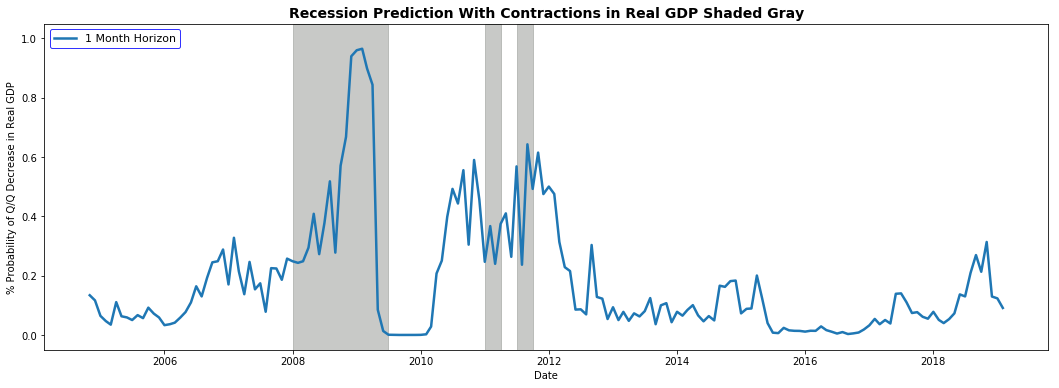

In [675]:
x = result1.index
a = result1.iloc[:,0]
b = result1.iloc[:,1]
c = result1.iloc[:,2]
d = result1.iloc[:,3]

fig, ax = plt.subplots(figsize=(18, 6))
#ax.plot(x, a, linewidth=2.5, zorder=2)
ax.plot(x, b, linewidth=2.5, zorder=2)
#ax.plot(x, c, linewidth=2.5, zorder=2)
#ax.plot(x, d, linewidth=2.5, zorder=2)
ax.scatter(x, a, s=0, zorder=1, label='_nolegend_')
ax.axvspan(x[38],x[56], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[74],x[77], color=sns.xkcd_rgb['grey'], alpha=0.5)
ax.axvspan(x[80],x[83], color=sns.xkcd_rgb['grey'], alpha=0.5)

ax.set_title('Recession Prediction With Contractions in Real GDP Shaded Gray', fontsize=14, fontweight='demi')

ax.legend(loc='upper left', fontsize=11, frameon=True).get_frame().set_edgecolor('blue')

ax.set_ylabel('% Probability of Q/Q Decrease in Real GDP')
ax.set_xlabel('Date')